In [1]:
# imports
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import librosa
import librosa.display
%matplotlib inline


# May of may not use
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
# datafiles
os.getcwd()
os.path.exists("..\\files\\")
# emotion.csv is a one-hot encoding table that tells what emotion is conveyed in each wave file
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
emotion = pd.read_csv("..\\files\\emotion.csv")
emotion = pd.DataFrame(
            {'file_name': emotion['file_name'], 
             'neutral': emotion['1'],
             'calm':emotion['2'],
             'happy':emotion['3'],
             'sad':emotion['4'],
             'angry':emotion['5'],
             'fearful': emotion['6'],
             'disgust':emotion['7'],
             'surprised': emotion['8']
            })
# ravdess_audio_file_attributes.csv has all the attributes for each audio file including modality, voice_channel, emotion, intensity, statement, Repetition, actor, gender of actor
audiofile_attributes = pd.read_csv("..\\files\\ravdess_audio_file_attributes.csv")
# not sure why I made this but i feel it may come in handy
audiofile_emotion = pd.DataFrame({'file': audiofile_attributes['file_name'], 'emotion':audiofile_attributes['Emotion']})

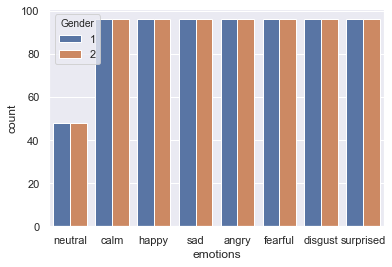

In [3]:
# Beginning of some quick visualizations
# All of my attributes are categorical, so I will just show boxplots
# These are plots for the entire dataset will be doing test train sets here soon 
sns.set(style="darkgrid")
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

emotionList = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
for i in range(1,9):
    audiofile_attributes.loc[audiofile_attributes['Emotion'] == i, 'emotions'] = emotionList[i-1]


emotionCountByGender = sns.countplot(x=audiofile_attributes['emotions'], hue = audiofile_attributes['Gender'])
# Why the count for neutral is half: Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

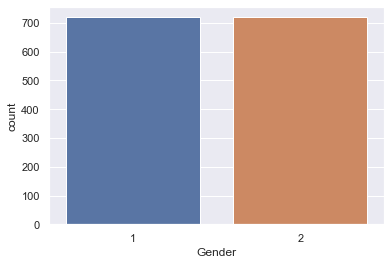

In [4]:
genderCount = sns.countplot(x=audiofile_attributes['Gender'])

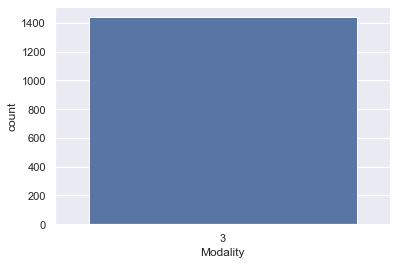

In [5]:
# Show that all are the same modality
# Modality (01 = full-AV, 02 = video-only, 03 = audio-only)
modalityCount = sns.countplot(x=audiofile_attributes['Modality'])
# All are audio-only files

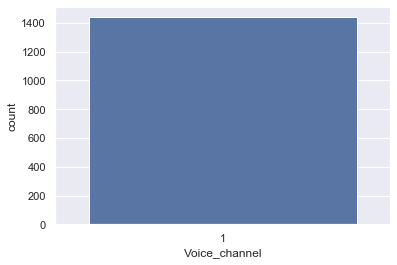

In [6]:
# Show that all are the same Vocal channel 
# Vocal channel (01 = speech, 02 = song)
VocalChannelCount = sns.countplot(x=audiofile_attributes['Voice_channel'])
# All are speech audio files

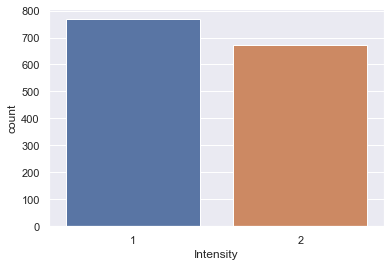

In [7]:
# Show the counts for intensity 
# Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

intensityCount = sns.countplot(x=audiofile_attributes['Intensity'])
# There are more normal intensity than strong, because neutral does not have a strong intensity

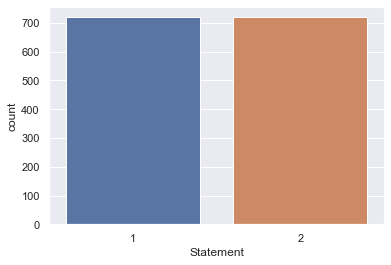

In [8]:
# Show the counts for Statements 
# Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

statementCount = sns.countplot(x=audiofile_attributes['Statement'])
# Each statement is said the same number of times

In [11]:
?

Object `librosa.time_to_samples(1, 2.5)` not found.


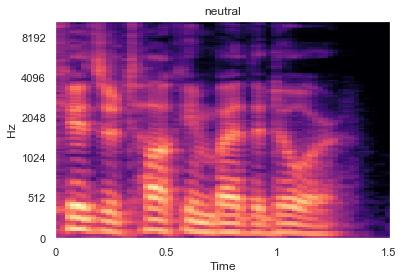

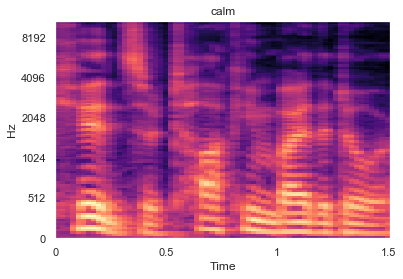

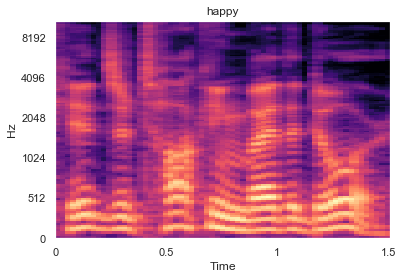

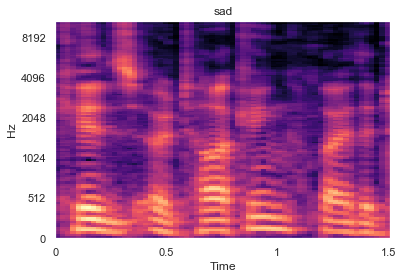

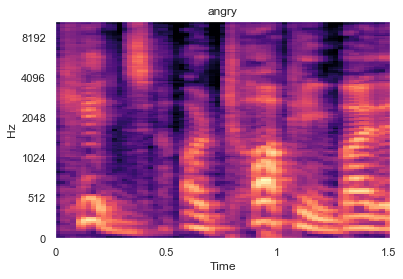

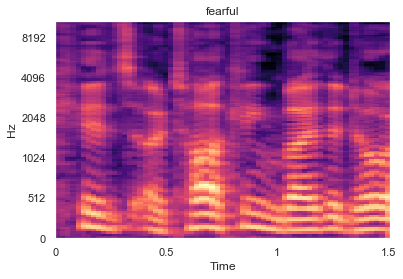

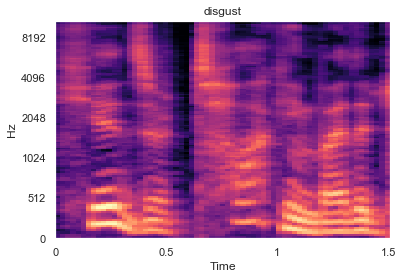

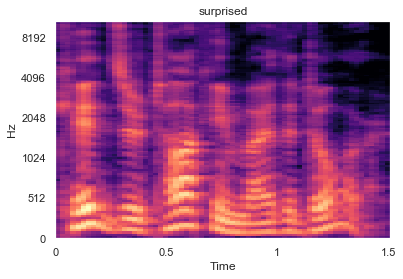

In [19]:
# Something else important to look at. The difference in emotion spectograms
# Actor: 1 Intensity: 1 
# 03-01-01-01-01-01-01.wav # change the third number for emotion
plt.figure(figsize=(6, 4))
for i in range(1, 9):
    filename = "03-01-0" + str(i) + "-01-01-01-01.wav"    
    filename = "..\\ravdess-emotional-speech-audio\\" + filename
    y, sr = librosa.load(filename)
    begin = librosa.time_to_samples(1)
    mid = librosa.time_to_samples(2.5)
    y = y[begin:mid]
    spect = librosa.feature.melspectrogram(y=y, sr=sr)
    spect = librosa.power_to_db(spect, ref=np.max)
    librosa.display.specshow(spect, y_axis='mel', x_axis='time')
    plt.title(emotionList[i-1])
    plt.show()

# There are subtle differences between the different emotions, will a CNN pick up on these differences 

In [10]:
# now to split into training and testing sets
# There are 1440 files, so maybe an 80-20 split

In [11]:
y = audiofile_attributes['Emotion']
X_train, X_test, y_train, y_test = train_test_split(audiofile_attributes, y, test_size=0.2)

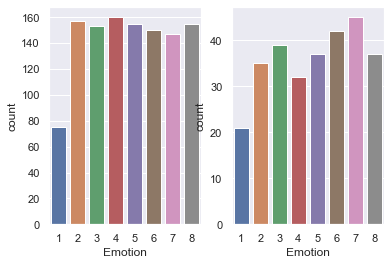

In [12]:
plt.subplot(1, 2, 1)
sns.countplot(x=X_train['Emotion'])
plt.subplot(1, 2, 2)
sns.countplot(x=X_test['Emotion'])

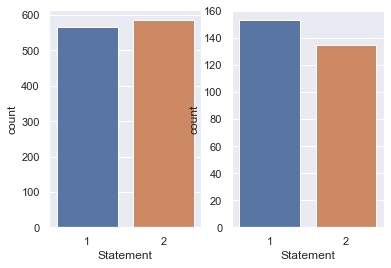

In [13]:
plt.subplot(1, 2, 1)
sns.countplot(x=X_train['Statement'])
plt.subplot(1, 2, 2)
sns.countplot(x=X_test['Statement'])

In [14]:
## before construction of Model
# Converting audio data into mel-spectogram


In [15]:
X_train

,file_name,Modality,Voice_channel,Emotion,Intensity,Statement,Repetition,Actor,Gender,emotions
315,03-01-03-01-01-02-04.wav,3,1,3,1,1,2,4,2,happy
351,03-01-03-01-02-01-16.wav,3,1,3,1,2,1,16,2,happy
872,03-01-06-01-01-01-09.wav,3,1,6,1,1,1,9,1,fearful
1317,03-01-08-01-02-01-22.wav,3,1,8,1,2,1,22,2,surprised
1275,03-01-08-01-01-02-04.wav,3,1,8,1,1,2,4,2,surprised
...,...,...,...,...,...,...,...,...,...,...
837,03-01-05-02-02-01-22.wav,3,1,5,2,2,1,22,2,angry
563,03-01-04-01-02-02-12.wav,3,1,4,1,2,2,12,2,sad
1054,03-01-06-02-02-02-23.wav,3,1,6,2,2,2,23,1,fearful
352,03-01-03-01-02-01-17.wav,3,1,3,1,2,1,17,1,happy


NameError: name 'Sequential' is not defined

In [ ]:
# A List of things to deal with 
# Will be using a cnn
# Need all images to be the same size: 1 sec to 3 sec <- this is the range that the actor is speaking
# kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio